In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [94]:
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transforms.ToTensor())

# Split the training data into train and validation sets
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

# Load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transforms.ToTensor())

# Define the batchsize
batch_size = 64

# Create the dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [119]:
# Define the model (VAE)
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc31 = nn.Linear(256, 128)
        self.fc32 = nn.Linear(256, 128)
        # Decoder
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)
        
    def encode(self, x):
        # Encoder
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Latent space
        mu = self.fc31(x)
        logvar = self.fc32(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        # Decoder
        z = F.relu(self.fc4(z))
        z = F.relu(self.fc5(z))
        # Output
        z = torch.sigmoid(self.fc6(z))
        return z
    
    def forward(self, x):
        # Encode
        mu, logvar = self.encode(x.view(-1, 784))
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Decode
        x = self.decode(z)
        return x, mu, logvar

In [121]:
# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Total loss
    return BCE + KLD

# Define the model
model = VAE()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the number of epochs
epochs = 20

# Define the training loop
for epoch in range(epochs):
    # Define the training loss
    train_loss = 0.0
    # Train the model
    model.train()
    for images, _ in trainloader:
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        recon_images, mu, logvar = model(images)
        # Compute the loss
        loss = loss_function(recon_images, images, mu, logvar)
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()
        # Update the training loss
        train_loss += loss.item()*images.size(0)
    # Compute the average training loss
    train_loss = train_loss/len(trainloader.dataset)
    # Define the validation loss
    val_loss = 0.0
    # Validate the model
    model.eval()
    for images, _ in valloader:
        # Forward pass
        recon_images, mu, logvar = model(images)
        # Compute the loss
        loss = loss_function(recon_images, images, mu, logvar)
        # Update the validation loss
        val_loss += loss.item()*images.size(0)
    # Compute the average validation loss
    val_loss = val_loss/len(valloader.dataset)
    # Print the losses
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))

Epoch: 1 	Training Loss: 11107.246532 	Validation Loss: 8861.075602
Epoch: 2 	Training Loss: 8392.461291 	Validation Loss: 8029.327687
Epoch: 3 	Training Loss: 7916.867525 	Validation Loss: 7727.388139
Epoch: 4 	Training Loss: 7666.238243 	Validation Loss: 7565.915402
Epoch: 5 	Training Loss: 7512.481750 	Validation Loss: 7470.242194
Epoch: 6 	Training Loss: 7405.722978 	Validation Loss: 7348.937972
Epoch: 7 	Training Loss: 7323.864518 	Validation Loss: 7295.017723
Epoch: 8 	Training Loss: 7263.617587 	Validation Loss: 7239.571507
Epoch: 9 	Training Loss: 7211.434559 	Validation Loss: 7198.222812
Epoch: 10 	Training Loss: 7171.728173 	Validation Loss: 7168.622693
Epoch: 11 	Training Loss: 7135.777593 	Validation Loss: 7142.264118
Epoch: 12 	Training Loss: 7104.876444 	Validation Loss: 7125.775577
Epoch: 13 	Training Loss: 7075.666325 	Validation Loss: 7082.910792
Epoch: 14 	Training Loss: 7057.309009 	Validation Loss: 7068.239172
Epoch: 15 	Training Loss: 7032.142784 	Validation Loss: 

/var/folders/vm/jwrfx2px5_1fqz5mkql4m40m0000gn/T/ipykernel_90997/2099660839.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images)


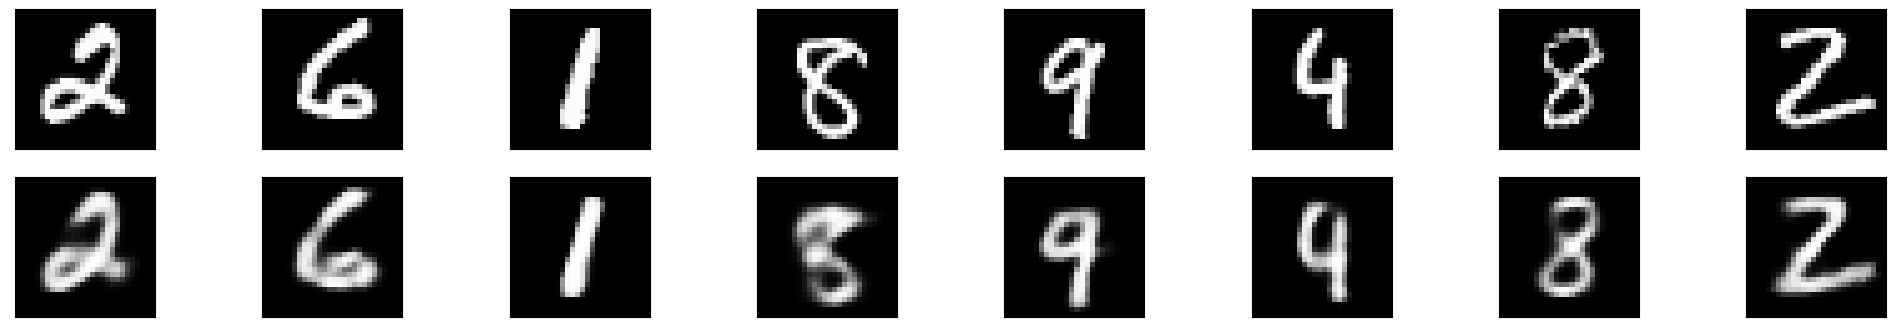

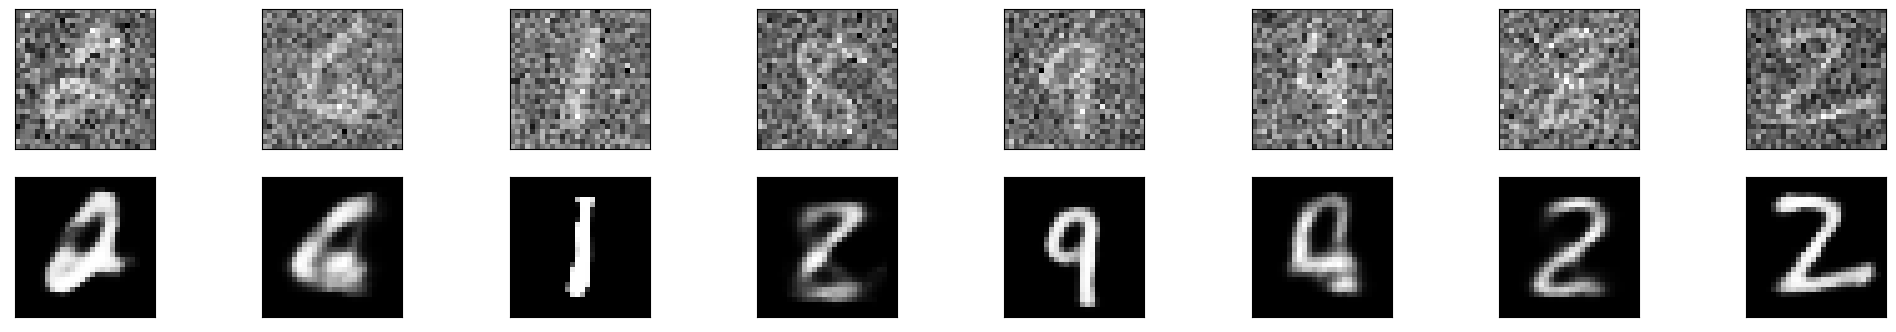

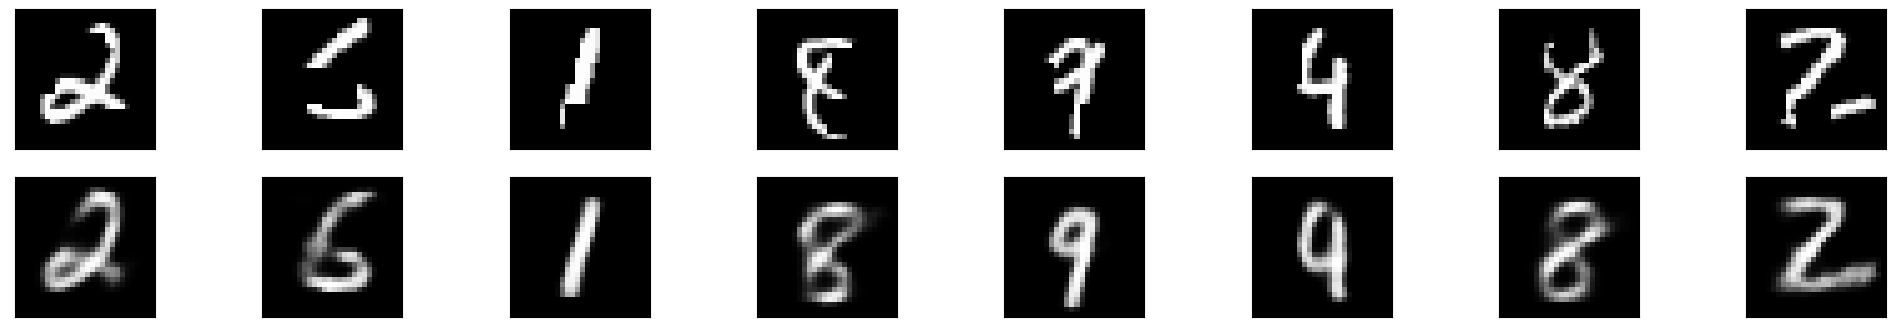

In [122]:
# Plot the reconstructions
with torch.no_grad():
    model.eval()
    images, _ = next(iter(testloader))
    recon_images, _, _ = model(images)
    images = images.numpy()
    recon_images = recon_images.view(batch_size, 1, 28, 28).detach().numpy()
    fig, axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(25,4))
    for iter_images, row in zip([images, recon_images], axes):
        for img, ax in zip(iter_images, row):
            ax.imshow(img.reshape(28, 28, 1), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    # Apply noise to the input images and plot the reconstructions
    images = torch.tensor(images)
    noisy_images = images.clone()
    noisy_images = noisy_images + 0.5 * torch.randn_like(noisy_images)
    recon_images, _, _ = model(noisy_images)
    noisy_images = noisy_images.numpy()
    recon_images = recon_images.view(batch_size, 1, 28, 28).detach().numpy()
    fig, axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(25,4))
    for iter_images, row in zip([noisy_images, recon_images], axes):
        for img, ax in zip(iter_images, row):
            ax.imshow(img.reshape(28, 28, 1), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    # Apply random masks to the input images and plot the reconstructions
    images = torch.tensor(images)
    masked_images = images.clone()
    mask_size = 7  # size of the mask
    for img in masked_images:
        for _ in range(3):
            x = np.random.randint(0, img.shape[1] - mask_size)
            y = np.random.randint(0, img.shape[2] - mask_size)
            img[:, x:x+mask_size, y:y+mask_size] = 0
    recon_images, _, _ = model(masked_images)
    masked_images = masked_images.numpy()
    recon_images = recon_images.view(batch_size, 1, 28, 28).detach().numpy()
    fig, axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(25,4))
    for iter_images, row in zip([masked_images, recon_images], axes):
        for img, ax in zip(iter_images, row):
            ax.imshow(img.reshape(28, 28, 1), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()